In [1]:
!pip install -qq transformers

In [2]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

Downloading scraped Google Play app store reviews

In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 41.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.2MB/s]


In [4]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


No missing values in the score and content/review field

Check the distribution of the target

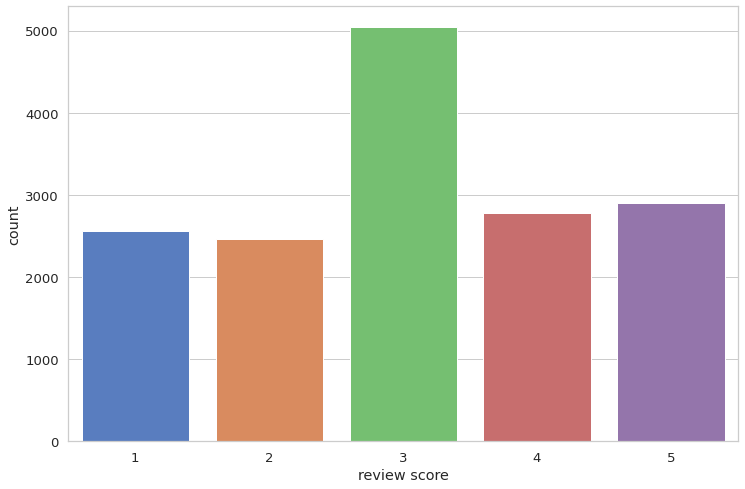

In [7]:
sns.countplot(df.score)
plt.xlabel('review score');

Not balanced but it is okay because I will combine the labels 1&2 for negative and 4&5 for positive

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df['score'].apply(to_sentiment)

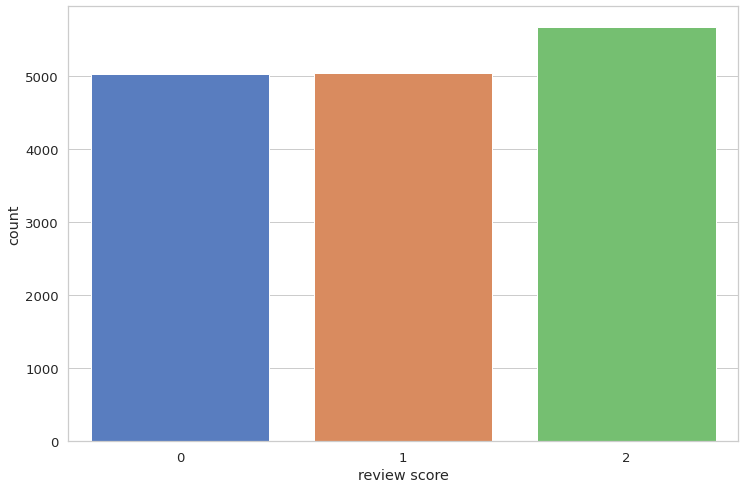

In [9]:
sns.countplot(df['sentiment'])
plt.xlabel('review score');

In [10]:
PRE_TRAINED_MODEL = 'roberta-base'

Using BERT pretrained tokenizer

In [11]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [12]:
sample_txt = "When was I last outside of my house? I have been stuck at home for 4 weeks and I don't like it."

In [13]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside of my house? I have been stuck at home for 4 weeks and I don't like it.
   Tokens: ['When', 'Ġwas', 'ĠI', 'Ġlast', 'Ġoutside', 'Ġof', 'Ġmy', 'Ġhouse', '?', 'ĠI', 'Ġhave', 'Ġbeen', 'Ġstuck', 'Ġat', 'Ġhome', 'Ġfor', 'Ġ4', 'Ġweeks', 'Ġand', 'ĠI', 'Ġdon', "'t", 'Ġlike', 'Ġit', '.']
Token IDs: [1779, 21, 38, 94, 751, 9, 127, 790, 116, 38, 33, 57, 4889, 23, 184, 13, 204, 688, 8, 38, 218, 75, 101, 24, 4]


In [14]:
tokenizer.special_tokens_map_extended

{'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True),
 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True),
 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True),
 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True),
 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True),
 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True),
 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True)}

Because our model input expects a fixed length input we need to decide what our max length will be. To get a better idea of a good length I will plot the distribution of the number of tokens in each review.

In [15]:
token_lens = []
for txt in df['content']:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

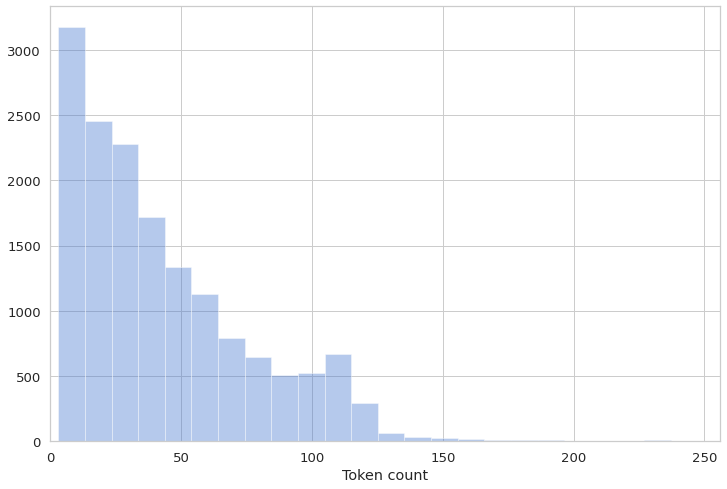

In [16]:
sns.distplot(token_lens, kde=False)
plt.xlim([0, 256]);
plt.xlabel('Token count');

From the above plot setting the max number of tokens to 160 seems to capture the vast majority of reviews.

Now I will create a pytorch Dataset

In [17]:
MAX_LEN = 160

## Create the Google Play reivew dataset class

In [18]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )
    
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Returning the review texts for easy model evaluation later

Split the data into train, val and test

In [19]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  """
  Helper function to load GPR datasets into dataloader
  """
  ds = GPReviewDataset(
    reviews=df['content'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
  )

In [30]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Returns what we expect

In [31]:
#data = next(iter(train_data_loader))
#data.keys()

In [32]:
#data['input_ids'][15]

In [33]:
class RoBERTaSentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RoBERTaSentimentClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL) # load pretrained BERT model
    self.drop = nn.Dropout(p=0.3) # add some dropout for better model generalisation
    self.linear_last = nn.Linear(self.roberta.config.hidden_size, n_classes) # add layer to produce 3 outputs
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.linear_last(output)

In [34]:
model = RoBERTaSentimentClassifier(3)
model = model.to(device)

The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4   

However I will go slightly higher since I am using a cosine schedule with a warmup we have only peak at the specified learning rate for a short time.

We could find our own optimal learning rate by plotting different learning rates and the corresponding loss on a graph and visually deciding but in the interest of time that will be skipped here.  
For more info: https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

In [35]:
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2.5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS


# Create a schedule with a learning rate that decreases linearly from the initial lr set in the 
# optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial 
# lr set in the optimizer. This helps with finding the min for our loss function (helps avoid
# local minima).
scheduler = get_cosine_schedule_with_warmup(
  optimizer,
  num_warmup_steps=5,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [36]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples   ):

  model = model.train()

  losses = []
  correct_predictions = 0

  for batch in data_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    targets = batch["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1) 

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # to control potential exploding gradients
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.7578708495162679 accuracy 0.6432855832333639
Val   loss 0.6151278221607208 accuracy 0.7280813214739518

Epoch 2/20
----------
Train loss 0.5523219711019008 accuracy 0.7701644202949687
Val   loss 0.5418790513277054 accuracy 0.7941550190597205

Epoch 3/20
----------
Train loss 0.3953956758632886 accuracy 0.8511749347258486
Val   loss 0.5387279951572418 accuracy 0.8233799237611182

Epoch 4/20
----------
Train loss 0.2957050842033283 accuracy 0.8935854914967187
Val   loss 0.5628147161006928 accuracy 0.8195679796696316

Epoch 5/20
----------
Train loss 0.23095508184258745 accuracy 0.9227295180297792
Val   loss 0.5165407609939575 accuracy 0.8627700127064803

Epoch 6/20
----------
Train loss 0.1876214934916616 accuracy 0.9411474137322702
Val   loss 0.6461680895090103 accuracy 0.8614993646759848

Epoch 7/20
----------
Train loss 0.16515449718540665 accuracy 0.9483452120527839
Val   loss 0.5891651976108551 accuracy 0.878017789072427

Epoch 8/20
----------
Trai

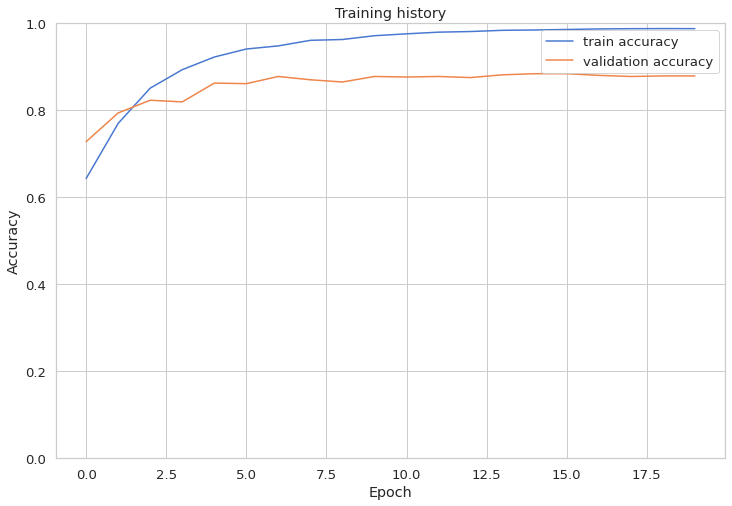

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [40]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8934010152284263

In [41]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)


      
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [42]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [49]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.88      0.90       245
     neutral       0.84      0.87      0.85       254
    positive       0.92      0.93      0.93       289

    accuracy                           0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



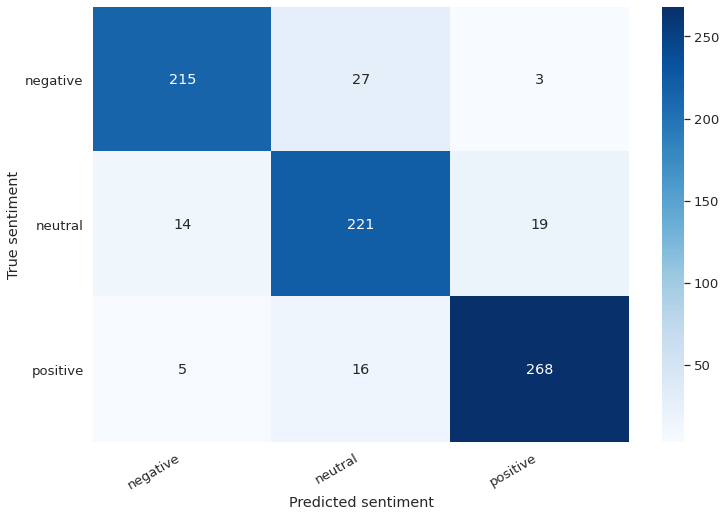

In [50]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

The model has a harder time classifying neutral reviews. It mistakes them for negative and positive with roughly equal frequencies.

In [51]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


I will now look at the confidence of the sentiment prediction

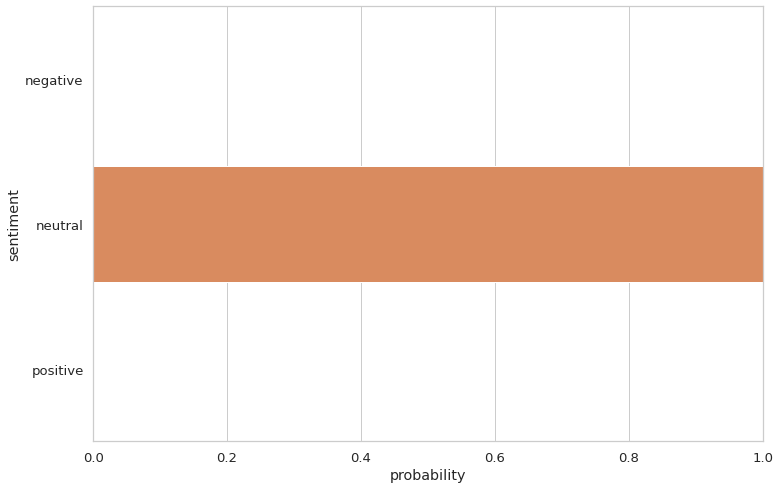

In [52]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);